In [1]:
import numpy as np
from PIL import Image, ImageDraw
import os
import json
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import random
from IPython.display import Image as displayImage
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
img_size = 28

def create_ring(image_size, center, radius, thickness, deformation=0):
    img = Image.new('L', (image_size, image_size), color=0)
    draw = ImageDraw.Draw(img)
    
    for angle in range(360):
        r = radius + random.uniform(-deformation, deformation)
        x = center[0] + r * np.cos(np.radians(angle))
        y = center[1] + r * np.sin(np.radians(angle))
        draw.ellipse([x-thickness/2, y-thickness/2, x+thickness/2, y+thickness/2], fill=255)
    
    return np.array(img)

def generate_dataset(num_images, image_size=img_size, save_dir='ring_generator_dataset'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    labels = []
    
    for i in range(num_images):
        center = (random.randint(5, image_size-5), random.randint(5, image_size-5))
        radius = random.randint(4, min(center[0], center[1], image_size-center[0], image_size-center[1])-1)
        thickness = random.uniform(0.2, 1.5)#*np.sqrt(radius)
        deformation = random.uniform(0.5, 3)
        
        img = create_ring(image_size, center, radius, thickness, deformation)
        
        img_pil = Image.fromarray(img)
        img_pil.save(f'{save_dir}/ring_image_{i}.png')
        
        # Store the ring properties as a label, now including radius
        label = {
            "center": center,
            "radius": radius,
            "thickness": thickness,
            "deformation": deformation
        }
        labels.append(label)
    
    # Save labels as JSON
    with open(f'{save_dir}/labels.json', 'w') as f:
        json.dump(labels, f, indent=2)

In [3]:
# Generate 10 images (for this project having a lot of images actually makes a difference!)
generate_dataset(5000)
print("Dataset generated successfully!")

Dataset generated successfully!


In [4]:
def load_single_ring_dataset(directory):
    images = []
    labels = []
    
    # Read labels from JSON file
    with open(os.path.join(directory, 'labels.json'), 'r') as f:
        labels_data = json.load(f)
    
    # Load images and process labels
    for i, label in enumerate(labels_data):
        filename = f'ring_image_{i}.png'
        img_path = os.path.join(directory, filename)
        if os.path.exists(img_path):
            # Load and normalize image
            img = Image.open(img_path).convert('L')
            img_array = np.array(img).astype('float32') / 255
            images.append(img_array)
            
            # Process label
            processed_label = [
                label['center'][0] / img.width,  # Normalize x coordinate
                label['center'][1] / img.height,  # Normalize y coordinate
                label['radius'] / img.width,  # Normalize radius
                label['thickness'],
                label['deformation']
            ]
            labels.append(processed_label)
        else:
            print(f"Warning: Image {filename} not found. Skipping.")
    
    # Ensure we have the same number of images and labels
    if len(images) != len(labels):
        print(f"Warning: Number of images ({len(images)}) does not match number of labels ({len(labels)})")
    
    return np.array(images), np.array(labels)

In [5]:
images, labels = load_single_ring_dataset('ring_generator_dataset')

In [6]:
class myDatasetLoader(DataLoader):
    def __init__(self, image, label):
        self.image = image
        self.label = label
        
    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        data  = self.image[idx]
        data  = torch.tensor(data[np.newaxis, ...])
        label = torch.tensor(self.label[idx])
        
        return data, label

In [7]:
# Hyperparameters
image_channels = 1  # Grayscale images
image_size = 28     # 28x28 images
latent_dim = 20     # Dimension of the latent space
batch_size = 128
learning_rate = 1e-3
num_epochs = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
mydataset = myDatasetLoader(images, labels)
dataloader = DataLoader(mydataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [9]:
class ConvVAE(nn.Module):
    def __init__(self, image_channels=1, latent_dim=20):
        super(ConvVAE, self).__init__()
        
        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),  # [batch, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),              # [batch, 64, 7, 7]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),             # [batch, 128, 3, 3]
            nn.ReLU(),
            nn.Flatten(),                                                      # [batch, 1152]
        )
        
        # Latent space
        self.fc_mu = nn.Linear(128 * 3 * 3, latent_dim)       # Mean of latent space
        self.fc_logvar = nn.Linear(128 * 3 * 3, latent_dim)   # Log variance of latent space
        
        # Decoder: Fully connected layer followed by transposed convolutions
        self.fc_decode = nn.Linear(latent_dim, 128 * 7 * 7)   # Start from a bigger dimension for transposed convs
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [batch, 64, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # [batch, 32, 28, 28]
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=3, stride=1, padding=1),  # [batch, 1, 28, 28]
            nn.Sigmoid()  # Output pixel values in [0, 1]
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Random noise
        z = mu + eps * std  # Reparameterization trick
        return z
    
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 128, 7, 7)  # Reshape to fit into the transposed convolutions
        x_recon = self.decoder(h)
        return x_recon
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

In [10]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (BCE)
    bce_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return bce_loss + kl_loss

In [28]:
# Initialize model, optimizer, and loss function
vae = ConvVAE(image_channels=image_channels, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar, _ = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset):.4f}')

Epoch 1, Loss: 1749.8862
Epoch 2, Loss: 993.9750
Epoch 3, Loss: 740.7038
Epoch 4, Loss: 633.9089
Epoch 5, Loss: 565.1499
Epoch 6, Loss: 525.9723
Epoch 7, Loss: 490.4205
Epoch 8, Loss: 464.4096
Epoch 9, Loss: 442.8677
Epoch 10, Loss: 425.8033
Epoch 11, Loss: 416.8491
Epoch 12, Loss: 404.3822
Epoch 13, Loss: 398.6421
Epoch 14, Loss: 388.1775
Epoch 15, Loss: 384.4281
Epoch 16, Loss: 379.9303
Epoch 17, Loss: 374.7313
Epoch 18, Loss: 368.8370
Epoch 19, Loss: 368.4304
Epoch 20, Loss: 363.1794
Epoch 21, Loss: 360.3849
Epoch 22, Loss: 358.0796
Epoch 23, Loss: 353.8486
Epoch 24, Loss: 349.1609
Epoch 25, Loss: 348.4374
Epoch 26, Loss: 344.1349
Epoch 27, Loss: 345.1831
Epoch 28, Loss: 340.4722
Epoch 29, Loss: 337.3474
Epoch 30, Loss: 340.5559
Epoch 31, Loss: 335.8554
Epoch 32, Loss: 335.8330
Epoch 33, Loss: 334.7217
Epoch 34, Loss: 330.7365
Epoch 35, Loss: 330.0864
Epoch 36, Loss: 327.6542
Epoch 37, Loss: 325.4400
Epoch 38, Loss: 324.4076
Epoch 39, Loss: 322.3121
Epoch 40, Loss: 320.3510
Epoch 41

In [31]:
# Set model to evaluation mode
vae.eval()

# Example to get latent variables for a sample batch
with torch.no_grad():
    sample_data = next(iter(dataloader))[0].to(device)
    mu, logvar = vae.encode(sample_data)
    z = vae.reparameterize(mu, logvar)  # Latent variables
    
    print(f'Latent Variables Shape: {z.shape}')  # Should be [batch_size, latent_dim]
    print(z)  # Output latent variables
    figs = vae.decode(z)

Latent Variables Shape: torch.Size([128, 20])
tensor([[-2.2199, -1.4579, -0.3050,  ..., -1.6211,  0.3581,  0.4645],
        [ 2.4002,  1.6628, -0.7405,  ...,  0.7215,  0.4410, -0.6919],
        [ 0.7279,  0.0407,  0.8045,  ...,  0.2481, -1.5341,  0.1246],
        ...,
        [-0.9425,  1.5124,  1.1243,  ..., -0.2202,  0.5080,  0.5473],
        [-0.6283, -0.0435,  1.3395,  ..., -1.1435, -0.3497, -1.7125],
        [ 0.3844, -0.5063,  1.3889,  ..., -1.1955, -1.0733,  1.7853]],
       device='cuda:0')


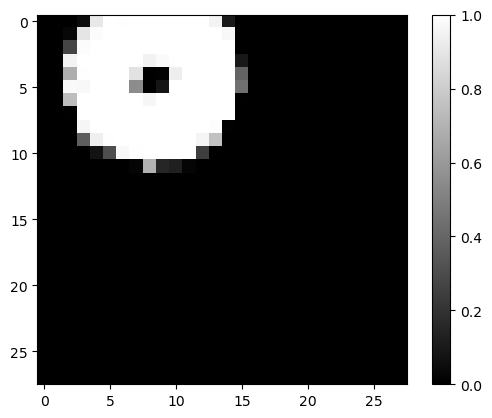

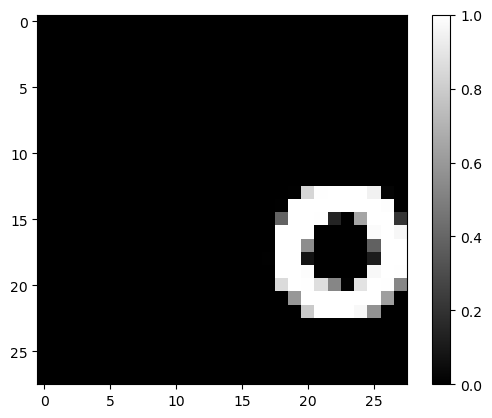

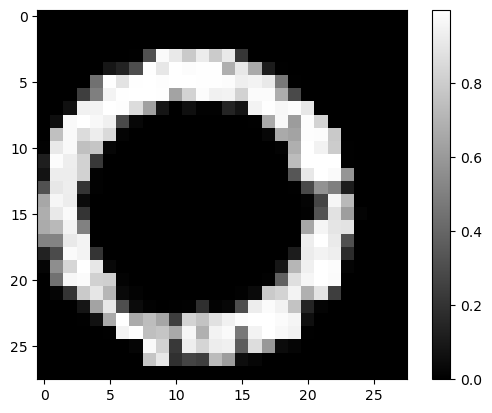

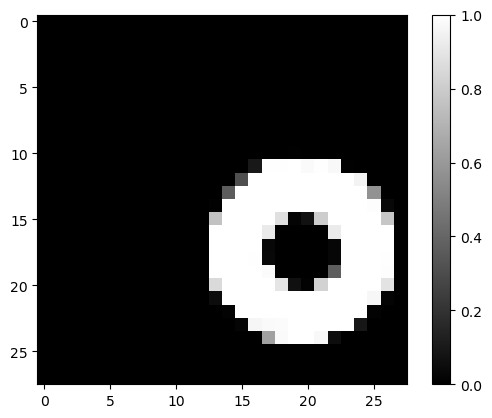

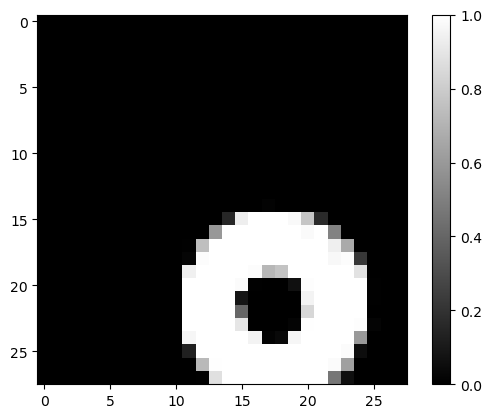

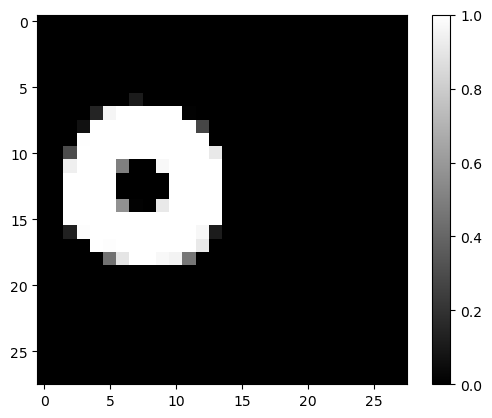

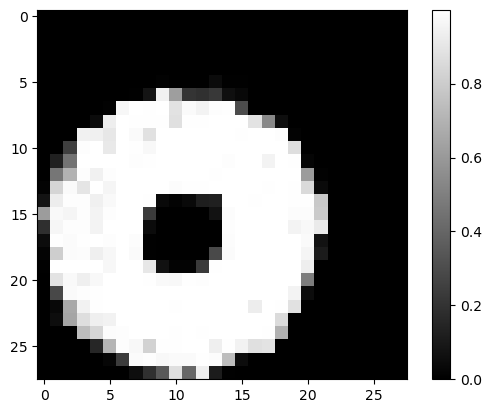

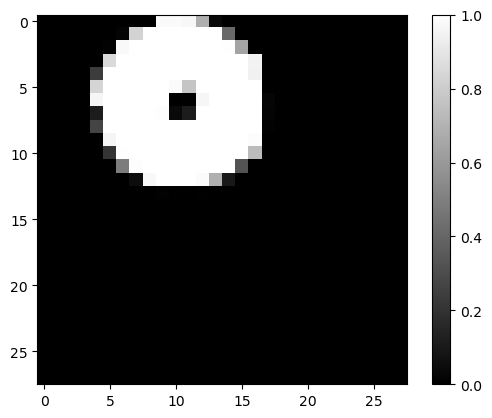

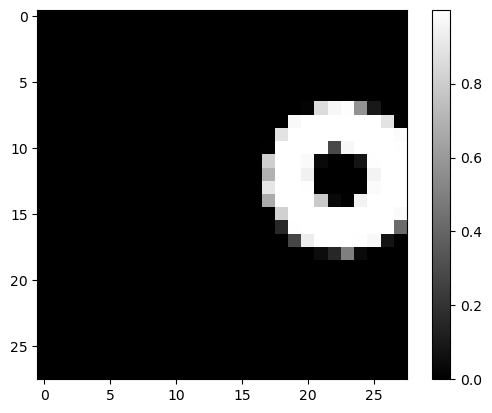

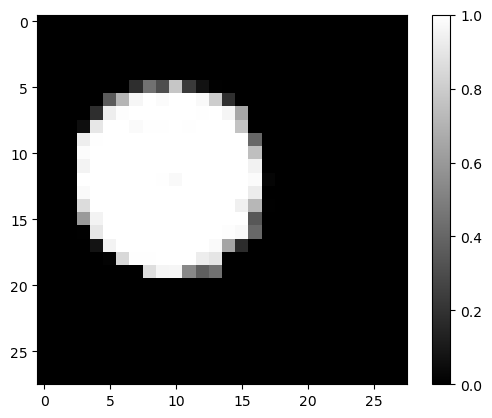

In [46]:
for i in range(10):
    plt.imshow(figs[i,0].cpu(), cmap="gray")
    plt.colorbar()
    plt.show()

In [104]:
mu_high = torch.max(mu, axis=0).values
mu_low  = torch.min(mu, axis=0).values
logvar_high = torch.max(mu, axis=0).values
logvar_low  = torch.min(mu, axis=0).values

In [115]:
test_mu = torch.rand(20).to(device)*(mu_high-mu_low) + mu_low
test_logvar = torch.rand(20).to(device)*(logvar_high-logvar_low) + logvar_low

In [184]:
test_z = vae.reparameterize(test_mu, test_logvar)

In [185]:
figs = vae.decode(test_z)

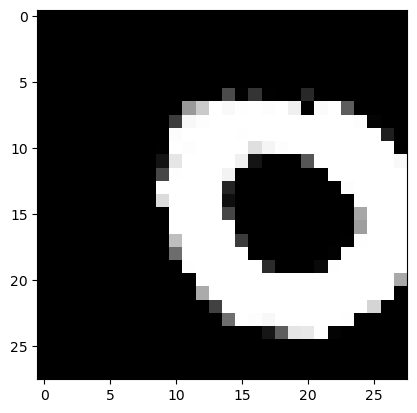

In [186]:
plt.imshow(figs[0,0].cpu().detach().numpy(), cmap="gray")

In [110]:
torch.save(vae.state_dict(), "./vae_params.pkl")

In [11]:
vae_test = ConvVAE(image_channels=image_channels, latent_dim=latent_dim).to(device)

In [12]:
vae_test.load_state_dict(torch.load("./vae_params.pkl"))

<All keys matched successfully>